# 03 앙상블 학습

## 앙상블 학습 개요
앙상블 학습(Ensemble Learning)을 통한 분류는 여러 개의 분류기(Classifier)를 생성하고 그 예측을 결합함으로써 보다 정확한 최종 예측을 도출하는 기법

앙상블 학습의 유형(보팅, 배깅, 부스팅)

[여러 개의 분류기가 투표를 통해 최종 예측 결과를 결정하는 방식]
- 보팅(Voting) : 일반적으로 서로 다른 알고리즘을 가진 분류기를 결합
- 배깅(Bagging) : 각각의 분류기가 모두 같은 유형의 알고리즘 기반이지만, 데이터 샘플링을 서로 다르게 가져가면서 학습을 수행해 보팅을 수행하는 것 ex. 랜덤포레스트 알고리즘

------
 
- 부스팅(Bagging) : 여러 개의 분류기가 순차적으로 학습을 수행하되, 앞에서 학습한 분류기가 예측이 틀린 데이터에 대해서 올바르게 예측할 수 있도록 다음 분류기에서 가중치(weight)를 부여하면서 학습과 예측을 진행하는 것 ex. 그래디언트 부스트, XGBoost, LightGBM

## 보팅 유형 - 하드 보팅(Hard Voting)과 소프트 보팅(Soft Voting)

1. 하드 보팅 - 다수결 원칙과 비슷

2. 소프트 보팅(일반적인 보팅) - 분류기들의 레이블 값 결정 확률을 모두 더하고 이를 평균해서 이들 중 확률이 가장 높은 레이블 값을 최종 보팅 결괏값으로 선정

In [14]:
# 보팅 분류기(Voting Classifier)

import pandas as pd

from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758


In [24]:
# 개별 모델은 로지스틱 회귀와 KNN임.
lr_clf = LogisticRegression(solver='liblinear')
knn_clf = KNeighborsClassifier(n_neighbors=8)

# 개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기
vo_clf = VotingClassifier( estimators=[('LR', lr_clf), ('KNN', knn_clf)], voting='soft' )

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, test_size=0.2, random_state=156)

# VotingClassifier 학습/예측/평가
vo_clf.fit(X_train, y_train)
pred = vo_clf.predict(X_test)
print('Voting 분류기 정확도 : {0:.4f}'.format(accuracy_score(y_test, pred)))

# 개별 모델의 학습/예측/평가
classifiers = [lr_clf, knn_clf]
for classifier in classifiers:
    classifier.fit(X_train, y_train)
    pred = classifier.predict(X_test)
    class_name= classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name, accuracy_score(y_test, pred)))

Voting 분류기 정확도 : 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


# 04 랜덤 포레스트

## 랜덤 포레스트의 개요 및 실습
- 배깅의 대표적인 알고리즘
- 기반 알고리즘은 결정 트리로서, 결정 트리의 쉽고 직관적인 장점을 그대로 가지고 있음.
- 여러 개의 결정 트리 분류기가 전체 데이터에서 배깅 방식으로 각자의 데이터를 샘플링해 개별적으로 학습을 수행한 뒤 최종적으로 모든 분류기가 보팅을 통해 예측을 결정
- 개별적인 분류기의 기반 알고리즘은 결정 트리이지만 개별 트리가 학습하는 데이터 세트는 전체 데이터에서 일부가 중첩되게 샘플링된 데이터 세트
- 여러 개의 데이터 세트를 중첩되게 분리하는 것을 '부트스트래핑(bootstrapping)' 분할 방식이라고 함

In [59]:
def get_new_feature_name_df(old_feature_name_df):
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1])
        if x[1] > 0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

def get_human_dataset():

    # 각 데이터 파일은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    featrue_name_df = pd.read_csv('./features.txt', sep='\s+', header=None, names=['column_index', 'column_name'])

    # 중복된 피처명을 수정하는 get_new_feature_name_df()를 이용, 신규 피처명 DataFrame 생성.
    new_feature_name_df = get_new_feature_name_df(feature_name_df)

    # DataFrame에 피처명을 칼럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:,1].values.tolist()

    # 학습 피처 데이터세트와 테스트 피처 데이터를 DataFrame으로 로딩. 칼럼명은 feature_name 적용
    X_train = pd.read_csv('./X_train.txt', sep='\s+', names=feature_name)
    X_test = pd.read_csv('./X_test.txt', sep='\s+', names=feature_name)

    # 학습 레이블과 테스트 레이블 데이터를 DataFrame으로 로딩하고 칼럼명은 action으로 부여
    y_train = pd.read_csv('./y_train.txt', sep='\s+', header=None, names=['action'])
    y_test = pd.read_csv('./y_test.txt', sep='\s+', header=None, names=['action'])

    # 로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# 결정 트리에서 사용한 get_human_dataset()를 이용해 학습/테스트용 DataFrame 반환
X_train, X_test, y_train, y_test = get_human_dataset()

# 랜덤 포레스트 학습 및 별도의 테스트 세트로 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0, max_depth=8)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, pred)
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy))

랜덤 포레스트 정확도: 0.9192


## 랜덤 포레스트 하이퍼 파라미터 및 튜닝
트리 기반의 앙상블 알고리즘의 단점은 하이퍼 파라미터가 너무 많고, 그로 인해 튜닝을 위한 시간이 많이 소모됨.

-> 트리 기반 자체의 하이퍼 파라미터가 원래 많은 데다 배깅, 부스팅, 학습, 정규화 등을 위한 하이퍼 파라미터까지 추가되므로 일반적으로 다른 ML 알고리즘에 비해 많을 수밖에 없음

- n_estimators : 랜덤 포레스트에서 결정 트리의 개수를 지정, 디폴트는 10개
- max_features : 결정 트리에 사용한 max_features 파라미터와 같음. 하지만 RandomForestClassifier의 기본 max_features는 'None'이 아니라 'auto', 즉 'sqrt'와 같음.
- max_depth나 min_samples_leaf, min_samples_split와 같이 결정 트리에서 과적합을 개선하기 위해 사용되는 파라미터가 랜덤 포레스트에도 똑같이 적용될 수 있음.

In [91]:
# y를 1차원 배열로 변환
y_train = y_train.squeeze()
y_test = y_test.squeeze()

In [99]:
from sklearn.model_selection import GridSearchCV

params={
    'max_depth':[8,16,24],
    'min_samples_leaf':[1,6,12],
    'min_samples_split':[2,8,16]
}

# RandomForestClassifier 객체 생성 후 GridSearchCV 수행
rf_clf=RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)
grid_cv=GridSearchCV(rf_clf, param_grid=params, cv=2, n_jobs=-1)
grid_cv.fit(X_train, y_train)

print('최고 하이퍼 파라미터:\n',grid_cv.best_params_)
print('최고 예측 정확도:{0:.4f}'.format(grid_cv.best_score_))

최고 하이퍼 파라미터:
 {'max_depth': 24, 'min_samples_leaf': 6, 'min_samples_split': 2}
최고 예측 정확도:0.9162


In [103]:
rf_clf1 = RandomForestClassifier(n_estimators=100, min_samples_leaf=6, max_depth=16, min_samples_split=2, random_state=0)
rf_clf1.fit(X_train, y_train)
pred = rf_clf1.predict(X_test)
print('예측 정확도: {0:.4f}'.format(accuracy_score(y_test, pred)))

예측 정확도: 0.9264


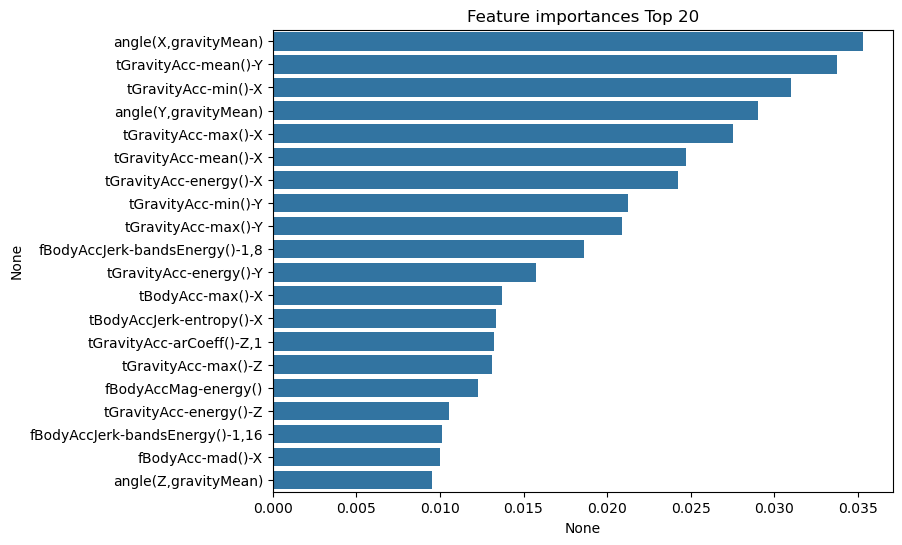

In [105]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = rf_clf1.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

# GBM(Gradient Boosting Machine)

## GBM의 개요 및 실습
- 부스팅 알고리즘은 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서 잘못 예측한 데이터에 가중치 부여를 통해 오류를 개선해 나가면서 학습하는 방식
- 부스팅의 대표적인 구현은 AdaBoost(Adaptive boosting)와 그래디언트 부스트가 있음.
- 에이다 부스트(AdaBoost)는 오류 데이터에 가중치를 부여하면서 부스팅을 수행하는 대표적인 알고리즘

#### 에이다부스트가 어떻게 학습하는가

1. 첫 번째 약한 학습기(weak learner)가 분류 기준 1로 +와 -를 분류한 것. 동그라미로 표시된 +데이터는 +데이터가 잘못 분류된 오류 데이터
2. 이 오류 데이터에 대해 가중치 값을 부여, 가중치가 부여된 오류 + 데이터는 다음 약한 학습기가 더 잘 분류할 수 있게 크기가 커짐
3. 두 번째 약한 학습기가 분류 기준 2로 +와 -를 분류, 마찬가지로 동그라미로 표시된 - 데이터는 잘못 분류된 오류 데이터
4. 잘못 분류된 이 - 오류 데이터에 대해 다음 약한 학습기가 잘 분류할 수 있게 더 큰 가중치를 부여(오류 - 데이터의 크기가 커짐)
5. 세 번째 약한 학습기가 분류 기준 3으로 +와 -를 분류하고 오류 데이터를 찾음. 에이다부스트는 이렇게 약한 학습기가 순차적으로 오류 값에 대해 가중치를 부여한 예측 결정 기준을 모두 결합해 예측을 수행
6. 맨 아래에는 첫 번째, 두 번째, 세 번째 약한 학습기를 모두 결합한 결과 예측, 개별 약한 학습기보다 훨씬 정확도가 높아졌음을 알 수 있음

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predicy(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도: {0:.4f}'.format(gb_accuracy))
print("GBM 수행 시간: {0:.1f} 초".format(time_time() - start_time))

### GBM 하이퍼 파라미터 소개
- loss: 경사 하강법에서 사용할 비용 함수를 지정. 특별한 이유 없으면 기본값인 'deviance'를 그래도 적용
- learning_rate: GBM이 학습을 진행할 때마다 적용하는 학습틀. Weak learner가 순차적으로 오류 값을 보정해 나가는 데 적용하는 계수, 0~1 사이 값 지정가능하며 기본값은 0.1
- n_estimators: weak learner의 개수, weak learner가 순차적으로 오류를 보정하므로 개수가 많을수록 예측 성능이 일정 수준까지는 좋아질 수 있음, 하지만 개수가 많을수록 수행 시간이 오래 걸림. 기본값은 100
- subsample: weak learner가 학습에 사용하는 데이터의 샘플링 비율, 기본값은 1이며, 이는 전체 학습 데이터를 기반으로 학습한다는 의미(0.5이면 학습 데이터의 50%). 과적합이 염려되는 경우 subsample을 1보다 작은 값으로 설정

# 06 XGBoost(eXtra Gradient Boost)

## XGBoost 개요
장점
- 뛰어난 예측 성능
- GBM 대비 빠른 수행 시간
- 과적합 규제
- Tree pruning
- 자체 내장된 교차 검증
- 결손값 자체 처리

초기의 독자적인 XGBoost 프레임워크 기반의 XGBoost를 "파이썬 래퍼 XGBoost 모듈"

------
사이킷런과 연동되는 모듈을 "사이킷런 래퍼 XGBoost 모듈"

In [14]:
# XGBoost 설치하기
!pip install xgboost==1.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 728.4/728.4 kB 4.2 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [1802 lines of output]
      /opt/anaconda3/lib/python3.12/site-packages/setuptools/dist.py:476: SetuptoolsDeprecationWarning: Invalid dash-separated options
      !!
      
              ********************************************************************************
              Usage of dash-separated 'description-file' will not be supported in future
              versions. Please use the underscore name 'description_file' instead.
      
              This deprecation is overdue, please update your project and remove deprecated
              calls to avoid build errors in the future.
      
              See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
              **************************

In [16]:
import xgboost as xgb
from xgboost import XGBClassifier

### 파이썬 래퍼 XGBoost 하이퍼 파라미터
- 일반 파라미터 : 일반적으로 실행 시 스레드의 개수나 silent 모드 등의 선택을 위한 파라미터로서 디폴트 파라미터 값을 바꾸는 경우는 거의 없음
- 부스트 파라미터 : 트리 최적화, 부스팅, regularization 등과 관련 파라미터 등을 지칭 -> 대부분의 파라미터
- 학습 태스크 파라미터 : 학습 수행 시의 객체 함수, 평가를 위한 지표 등을 설정하는 파라미터

### 주요 일반 파라미터
- booster : gbtree(tree based model) 또는 gblinear(linear model) 선택, 디폴트는 gbtree임
- silent : 디폴트는 0이며, 출력 메세지를 나타내고 싶지 않을 경우 1로 설정
- nthread : CPU의 실행 스레드 개수를 조정하며, 디폴트는 CPU의 전체 스레드를 다 사용하는 것임. 멀티 코어/스레드 CPU 시스템에서 전체 CPU를 사용하지 않고 일부 CPU만 사용해 ML 애플리케이션을 구동하는 경우에 변경함.

### 주요 부스터 파라미터
- eta(defalult=0.3 alias: learning_rate] : GBM의 학습률(learning rate)과 같은 파라미터임. 0~1 사이의 값을 정하며 부스팅 스텝을 반복적으로 수행할 때 업데이트되는 학습률 값. 파이썬 래퍼 기반의 xgboost를 이용할 경우 디폴트는 0.3 사이킷런 래퍼 클래스를 이용할 경우 eta는 learning_rate 파라미터로 대체되며, 디폴트는 0.1임. 보통은 0.01~0.2 사이의 값을 선호
- num_boost_rounds : GBM의 n_estimators와 같은 파라미터
- min_child_weight[default=1] : 트리에서 추가적으로 가지를 나눌지를 결정하기 위해 필요한 데이터들의 weight 총합. min_child_weight이 클수록 분할을 자제함. 과적합을 조절하기 위해 사용
- gamma[default=0, alias : min_split_loss] : 트리의 리프 노드를 추가적으로 나눌지를 결정할 최소 손실 감소 값임. 해당 값보다 큰 손실(loss)이 감소된 경우에 리프 노드를 분리. 값이 클수록 과적합 감소 효과가 있음.
- max_depth[defalut=6] : 트리 기반의 알고리즘의 max_depth와 같음. 0을 지정하면 깊이에 제한이 없음. max_depth가 높으면 특정 피처 조건에 특화되어 룰 조건이 만들어지므로 과적합 가능성이 높아지며 보통은 3~10 사이의 값을 적용
- sub_sample[default=1] : GBM의 subsample과 동일. 트리가 커져서 과적합되는 것을 제어하기 위해 데이터를 샘플링하는 비율을 지정함. sub_sample=0.5로 지정하면 전체 데이터의 절반을 트리를 새엇ㅇ하는 데 사용. 0~1 사이의 값이 가능하나 일반적으로 0.5~1 사이의 값을 사용
- colsample_bytree[default=1] : GBM의 max_features와 유사. 트리 생성에 필요한 피처(칼럼)를 임의로 샘플링하는 데 사용. 매우 많은 피처가 있는 경우 과적합을 조정하는 데 적용
- lambda[default=1, alias: reg_lambda] : L2 Regularization 적용 값임. 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있음
- alpha[default=0, alias: reg_alpha] : L1 Regularization 적용 값임. 피처 개수가 많을 경우 적용을 검토하며 값이 클수록 과적합 감소 효과가 있음.
- scale_pos_weight[default=1] : 특정 값으로 치우친 비대칭한 클래스로 구성된 데이터 세트의 균형을 유지하기 위한 파라미터임.

### 학습 태스크 파라미터
- objective : 최솟값을 가져야 할 손실 함수를 정의. XGBoost는 많은 유형의 손실함수를 사용 가능함. 사용되는 손실함수는 이진 분류인지 다중 분류인지에 따라 달라짐.
- binary:logistic : 이진 분류일 때 적용함.
- multi:softmax: 다중 분류일 때 적용. 손실함수가 multi:softmax일 경우에는 레이블 클래스의 개수인 num_class 파라미터를 지정해야 함
- multi:softprob: multi:softmax와 유사하나 개별 레이블 클래스의 해당되는 예측 확률을 반환함.
- eval_metric : 검증에 사용되는 함수를 정의함. 기본값은 회귀인 경우는 rmse, 분류일 경우에는 error임.

#### eval_metric의 값 유형
- rmse : Root Mean Square Error
- mae : Mean Absolute Error
- logloss : Negative log-likelihood
- error : Binary classifacation error rate (0.5 threshold)
- merror : Multicalss classification error rate
- mlogloss : Multiclass logloss
- auc : Area under the curve

#### 과적합 문제가 심각할 때
- eta 값을 낮춤(0.01~0.1). eta 값을 낮출 경우 num_round(또는 n_estimators)는 반대로 높여줘야 함
- max_depth 값을 낮춤
- min_child_weight 값을 높임
- gamma 값을 높임
- 또한 subsample과 colsample_bytree를 조정하는 것도 트리가 너무 복잡하게 생성되는 것을 막아 과적합 문제에 도움이 될 수 있음

In [26]:
import xgboost

print(xgboost.__version__)

3.0.0


In [35]:
## 파이썬 래퍼 XGBoost 적용 - 위스콘신 유방암 예측
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head(3)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [37]:
# label 값 분포 확인
# 악성(malignant)가 0 값, 양성(benign)이 1 값
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [39]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label임. Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [41]:
# 만약 구버전 XGboost에서 DataFrame으로 Dmatrix 생성이 안 될 경우 X_train.values로 넘파이 변환
# 학습, 검증, 테스트용 DMatrix를 생성
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [43]:
params = {'max_depth':3, 'eta':0.05, 'objective':'binary:logistic', 'eval_metric':'logloss'}
num_rounds = 400

- max_depth(트리 최대 깊이)는 3
- 학습률 eta는 0.1(XGBClassifier를 사용할 경우 eta가 아니라 learning_rate임)
- 예제 데이터가 0 또는 1 이진 분류이므로 목적함수는 이진 로지스틱
- 오류 함수의 평가 성능 지표는 logloss
- num_rounds(부스팅 반복 횟수)는 400회

In [50]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval'로 명기
eval_list = [(dtr, 'train'), (dval, 'eval')] # 또는 eval_list = [(dval, 'eval')] 만 명기해도 무방

# 하이퍼 파라미터와 Early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtr, num_boost_round = num_rounds, early_stopping_rounds=50, evals=eval_list)

[0]	train-logloss:0.62473	eval-logloss:0.63088
[1]	train-logloss:0.58662	eval-logloss:0.60461
[2]	train-logloss:0.55210	eval-logloss:0.58205
[3]	train-logloss:0.52068	eval-logloss:0.56165
[4]	train-logloss:0.49173	eval-logloss:0.54101
[5]	train-logloss:0.46517	eval-logloss:0.52206
[6]	train-logloss:0.44009	eval-logloss:0.50271
[7]	train-logloss:0.41646	eval-logloss:0.48606
[8]	train-logloss:0.39505	eval-logloss:0.46961
[9]	train-logloss:0.37523	eval-logloss:0.45485
[10]	train-logloss:0.35682	eval-logloss:0.44120
[11]	train-logloss:0.33964	eval-logloss:0.43123
[12]	train-logloss:0.32279	eval-logloss:0.41962
[13]	train-logloss:0.30783	eval-logloss:0.40848
[14]	train-logloss:0.29308	eval-logloss:0.39857
[15]	train-logloss:0.27928	eval-logloss:0.38945
[16]	train-logloss:0.26681	eval-logloss:0.38171
[17]	train-logloss:0.25498	eval-logloss:0.37381
[18]	train-logloss:0.24352	eval-logloss:0.36656
[19]	train-logloss:0.23307	eval-logloss:0.36014
[20]	train-logloss:0.22290	eval-logloss:0.35395
[2

In [52]:
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값을 결정하여 list 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:', preds[:10])

predict() 수행 결괏값을 10개만 표시, 예측 확률 값으로 표시됨
[0.938 0.004 0.776 0.058 0.975 1.    0.999 0.999 0.998 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [56]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def get_clf_eval(y_test, pred, pred_proba=None):
    print("오차 행렬:\n", confusion_matrix(y_test, pred))
    print("정확도: {:.4f}".format(accuracy_score(y_test, pred)))
    print("정밀도: {:.4f}".format(precision_score(y_test, pred)))
    print("재현율: {:.4f}".format(recall_score(y_test, pred)))
    print("F1: {:.4f}".format(f1_score(y_test, pred)))

In [58]:
get_clf_eval(y_test, preds, pred_probs)

오차 행렬:
 [[35  2]
 [ 2 75]]
정확도: 0.9649
정밀도: 0.9740
재현율: 0.9740
F1: 0.9740


<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

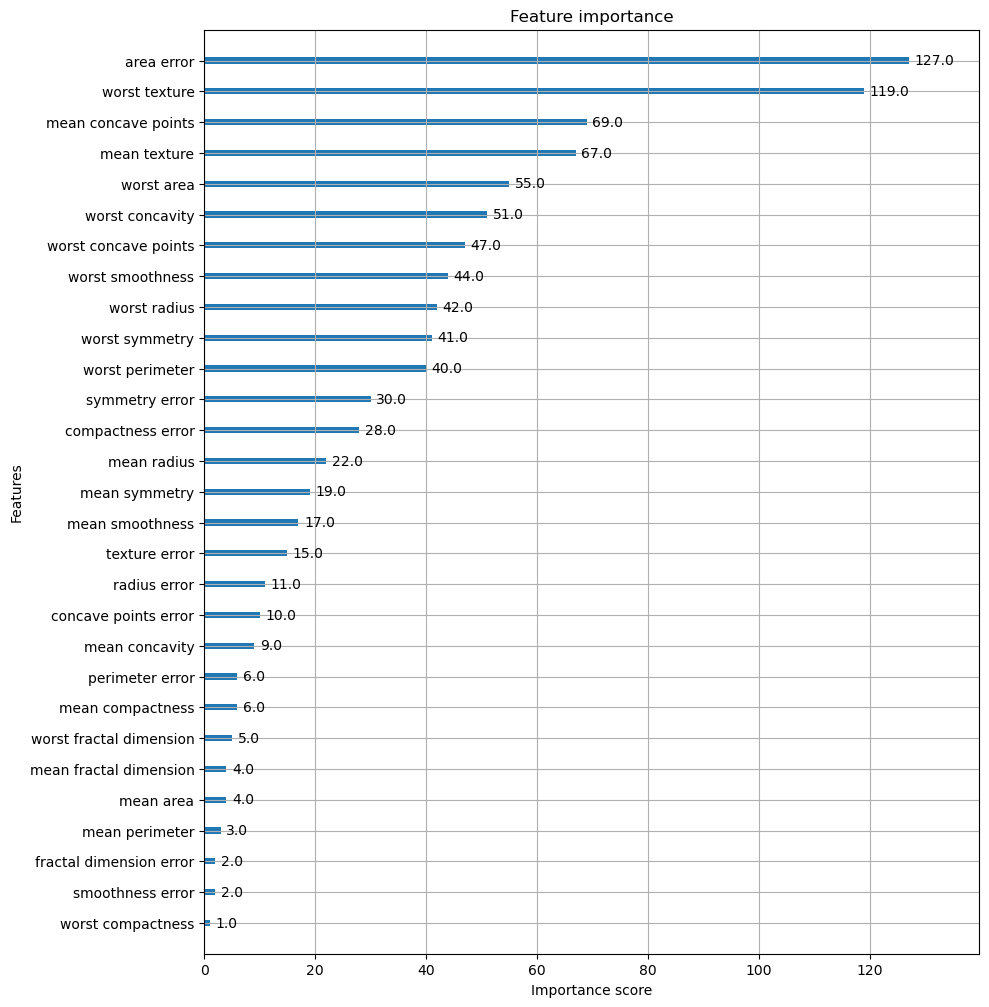

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model, ax=ax)

## 사이킷런 래퍼 XGBoost의 개요 및 적용
- 크게 분류를 위한 래퍼 클래스인 XGBClassifier, 회귀를 위한 래퍼 클래스인 XGBRegressor임.
- XGBClassifier는 기존 사이킷런에서 일반적으로 사용하는 하이퍼 파라미터와 호환성 유지를 위해 기존 xgboost 모듈에서 사용하던 네이티브 하이퍼 파라미터를 몇 개 수정
- eta -> learning_rate, sub_sample -> subsample, lambda -> reg_lambda, alpha -> reg_alpha

In [64]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

# Warning 메세지를 없애기 위해 eval_metric 값을 XGBClassifier 생성 인자로 입력
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

In [66]:
get_clf_eval(y_test,w_preds, w_pred_proba)

오차 행렬:
 [[34  3]
 [ 1 76]]
정확도: 0.9649
정밀도: 0.9620
재현율: 0.9870
F1: 0.9744


In [88]:
from xgboost import XGBClassifier

xgb_wrpper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_Test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]

[0]	validation_0-logloss:0.62473	validation_1-logloss:0.63088
[1]	validation_0-logloss:0.58662	validation_1-logloss:0.60461
[2]	validation_0-logloss:0.55210	validation_1-logloss:0.58205
[3]	validation_0-logloss:0.52068	validation_1-logloss:0.56165
[4]	validation_0-logloss:0.49173	validation_1-logloss:0.54101
[5]	validation_0-logloss:0.46517	validation_1-logloss:0.52206
[6]	validation_0-logloss:0.44009	validation_1-logloss:0.50271
[7]	validation_0-logloss:0.41646	validation_1-logloss:0.48606
[8]	validation_0-logloss:0.39505	validation_1-logloss:0.46961
[9]	validation_0-logloss:0.37523	validation_1-logloss:0.45485
[10]	validation_0-logloss:0.35682	validation_1-logloss:0.44120
[11]	validation_0-logloss:0.33964	validation_1-logloss:0.43123
[12]	validation_0-logloss:0.32279	validation_1-logloss:0.41962
[13]	validation_0-logloss:0.30783	validation_1-logloss:0.40848
[14]	validation_0-logloss:0.29308	validation_1-logloss:0.39857
[15]	validation_0-logloss:0.27928	validation_1-logloss:0.38945
[1

NameError: name 'X_Test' is not defined

In [96]:
get_clf_eval(y_test, ws50_preds, ws50_pred_proba)

NameError: name 'ws50_preds' is not defined

In [98]:
# early_stopping_rounds를 10으로 설정하고 재학습.
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=10, eval_metric='logloss', eval_set=evals, verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:,1]
get_clf_eval(y_test, ws10_preds, ws10_pred_proba)

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

<Axes: title={'center': 'Feature importance'}, xlabel='Importance score', ylabel='Features'>

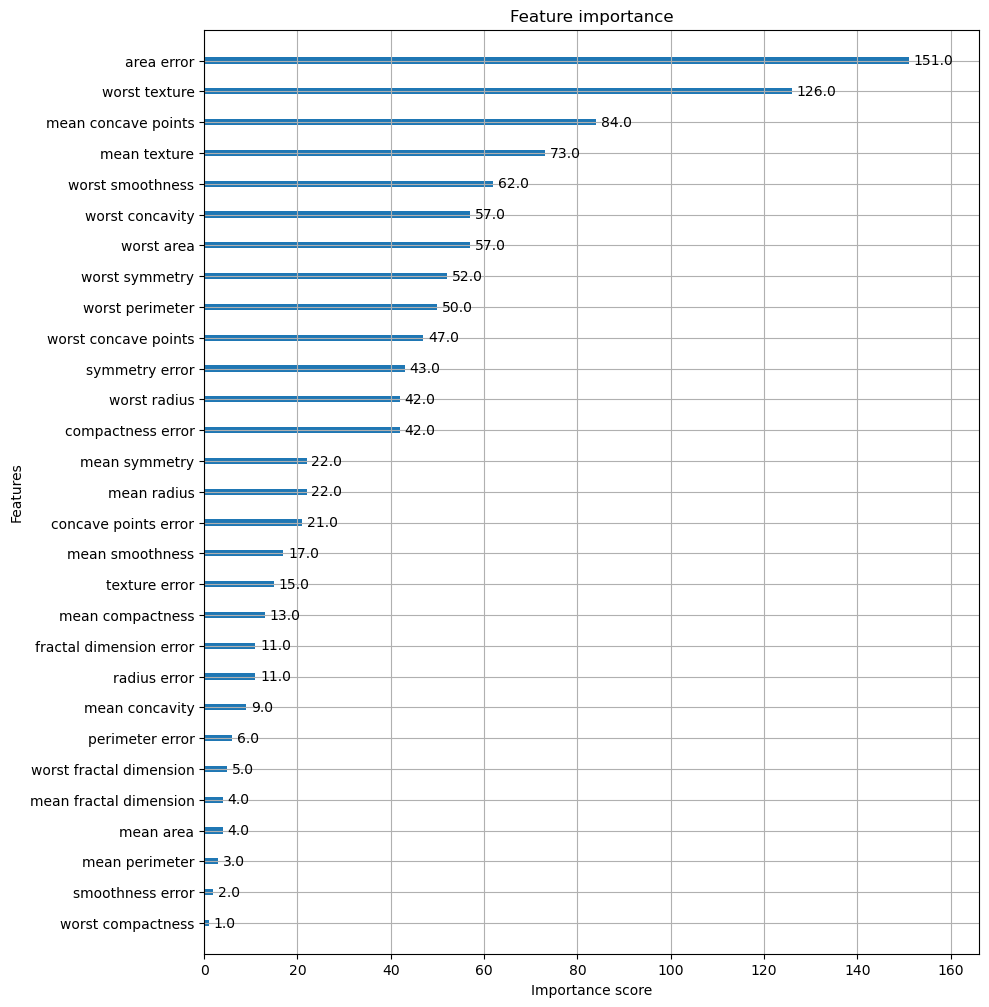

In [104]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10,12))
# 사이킷런 래퍼 클래스를 입력해도 무방.
plot_importance(xgb_wrapper, ax=ax)